## Final Model

In [ ]:
import sys
import inspect
import warnings

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
import joblib

In [ ]:
# Add the scripts directory to the sys path
sys.path.append("../src/data")
sys.path.append("../src/features")

from make_dataset import get_data
from data_processor import DataProcessor

In [3]:
# suppres warnings
warnings.filterwarnings("ignore")

# Show all rows and columns in the display
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

### Create Model object

In [9]:
dp = DataProcessor(
    cols_to_remove=[
        "parcelid",
        "propertyzoningdesc",
        "rawcensustractandblock",
        "regionidneighborhood",
        "regionidzip",
        "censustractandblock",
    ],
    datecol="transactiondate",
)

xgb_reg = xgb.sklearn.XGBRegressor(
    learning_rate=0.01,
    n_estimators=1039,
    max_depth=3,
    min_child_weight=1,
    gamma=0.4,
    max_delta_step=0,
    subsample=1.0,
    colsample_bytree=0.9,
    colsample_bylevel=1,
    colsample_bynode=1,
    reg_lambda=1,
    reg_alpha=1,
    scale_pos_weight=1,
    missing=None,
    objective="reg:squarederror",
    eval_metric="mae",
    seed=0,
    booster="gbtree",
    verbosity=0,
    nthread=-1,
)

final_model = Pipeline([("dataprocessor", dp), ("xgb_reg", xgb_reg)])

### Fit Final Model

In [6]:
# get the train data
X_train, y_train = get_data(data_string="train")

In [10]:
final_model.fit(X_train, y_train)

Pipeline(steps=[('dataprocessor',
                 <data_processor.DataProcessor object at 0x000002359CE9C978>),
                ('xgb_reg',
                 XGBRegressor(colsample_bytree=0.9, eval_metric='mae',
                              gamma=0.4, learning_rate=0.01, n_estimators=1039,
                              nthread=-1, objective='reg:squarederror',
                              reg_alpha=1, seed=0, subsample=1.0,
                              verbosity=0))])

### Score Test Dataset

In [11]:
# get the test data
X_test, y_test = get_data(data_string="test")

In [13]:
y_pred = final_model.predict(X_test)

### Evaluate Model and Compare with Baseline

In [17]:
print("XGBoost model - {0:.5f}".format(mean_absolute_error(y_test, y_pred)))

XGBoost model - 0.06999


In [20]:
y_pred_baseline = pd.Series(np.zeros(len(y_test)))
y_pred_baseline[:] = y_train.median()
print("XGBoost model - {0:.4f}".format(mean_absolute_error(y_test, y_pred_baseline)))

XGBoost model - 0.0697


##### As explained in previous notebook, we can try some more feature engineering, dimensionality reduction or/and try other models such as Gradient Boosting, AdaBoost to see if we can reduce MAE further

### Plot the Model Results

#### Actuals vs Predictions

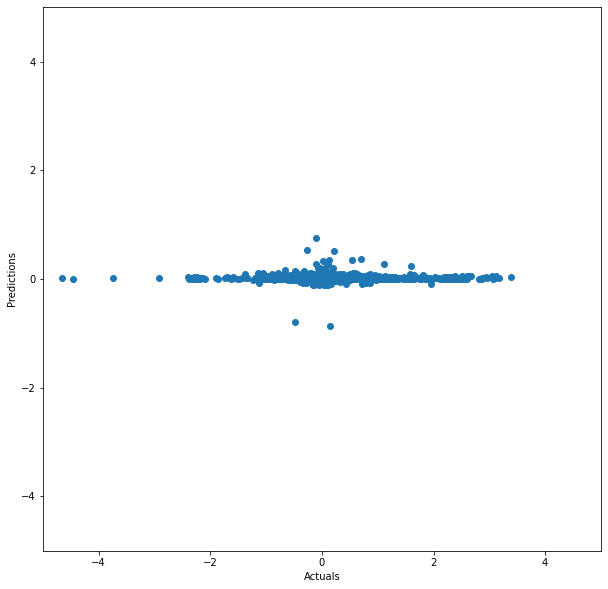

In [78]:
plt.figure(figsize=(10, 10))
plt.scatter(y_test, y_pred)
plt.xlabel("Actuals")
plt.ylabel("Predictions")
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.show()

Actuals vary from -4 to 4 whereas our predictions vary from -1 to 1. Our predictive model lacks in this aspect.

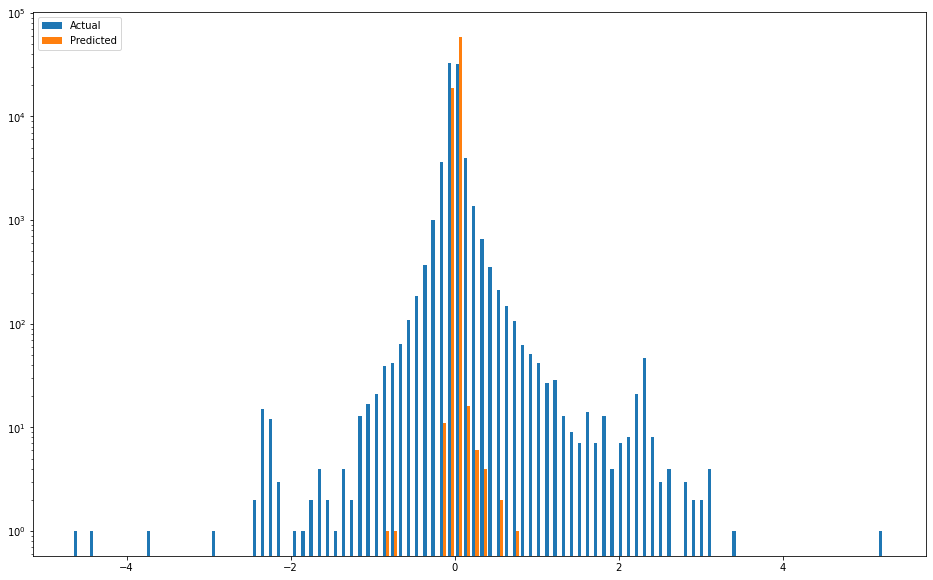

In [87]:
plt.figure(figsize=(16, 10))
plt.hist([y_test, y_pred], label=["Actual", "Predicted"], bins=100)
plt.yscale("log")
plt.legend(loc="upper left")
plt.show()

Predicted values has less variance compared to the actuals

#### Feature Importances

<AxesSubplot:title={'center':'Feature importance'}, ylabel='Features'>

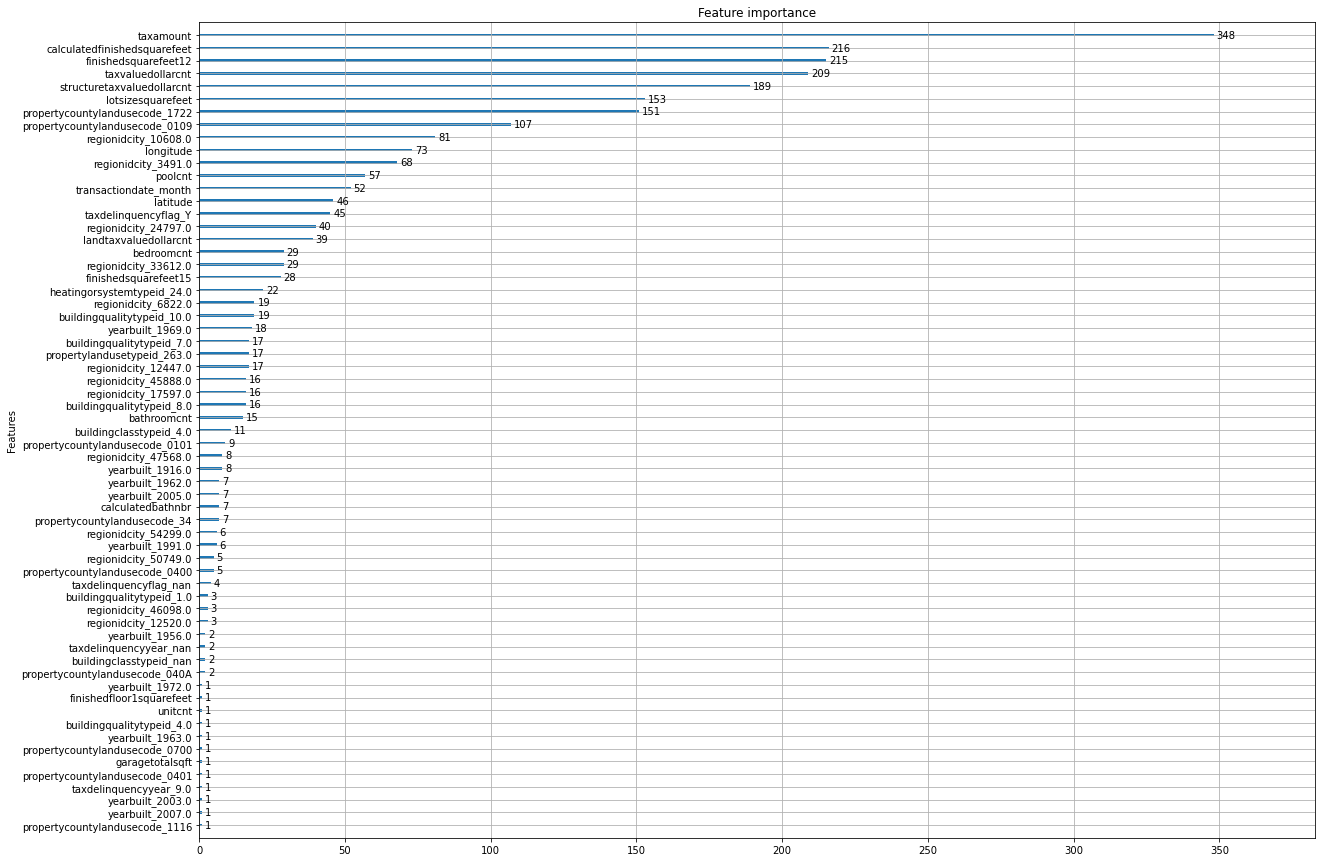

In [60]:
plt.figure(figsize=(20, 15))
xgb.plot_importance(xgb_reg, xlabel=None, ax=plt.gca())

#### Model Explainability using SHAP

In [62]:
X_test_transformed = dp.transform(X_test)

In [63]:
explainer = shap.TreeExplainer(xgb_reg)
shap_values = explainer.shap_values(X_test_transformed)

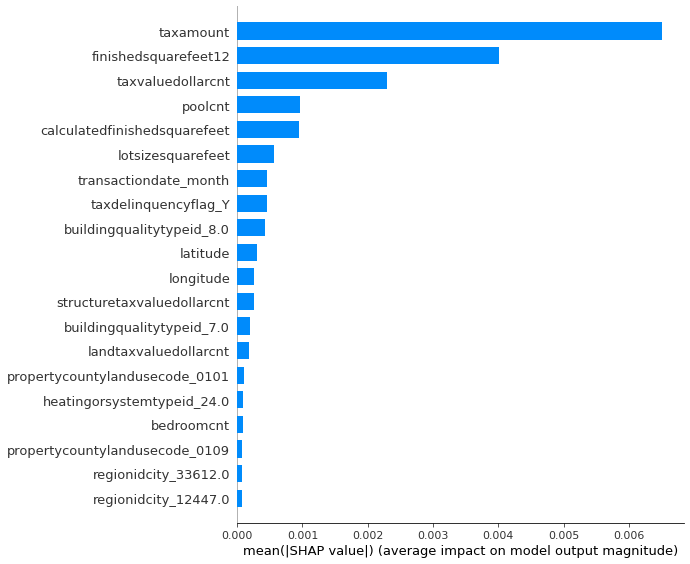

In [64]:
shap.summary_plot(shap_values, X_test_transformed, plot_type="bar")

The features that are having greater impact on the predictions are

1. taxamount - The total property tax assessed for that assessment year
2. finishedsquarefeet12 - Finished living area
3. taxvaluedollarcnt - The total tax assessed value of the parcel
4. poolcnt -  Number of pools on the lot (if any)
5. calculatedfinishedsquarefeet -  Calculated total finished living area of the home 
6. lotsizesquarefeet -  Area of the lot in square feet
7. transactiondate_month - month when the sale happened
8. taxdelinquencyflag_Y - Property taxes for this parcel are past due as of 2015
9. buildingqualitytypeid -  Overall assessment of condition of the building from best (lowest) to worst (highest)
10. latitude
11. longitude
`

Since we are predicting **logerror = log(Zestimate) - log(SalePrice)**, we are predicting where Zillow model (predictng Zestimate) is lacking and what features are contributing to it. The above 10 features can probably help improve Zillow model with its prediction

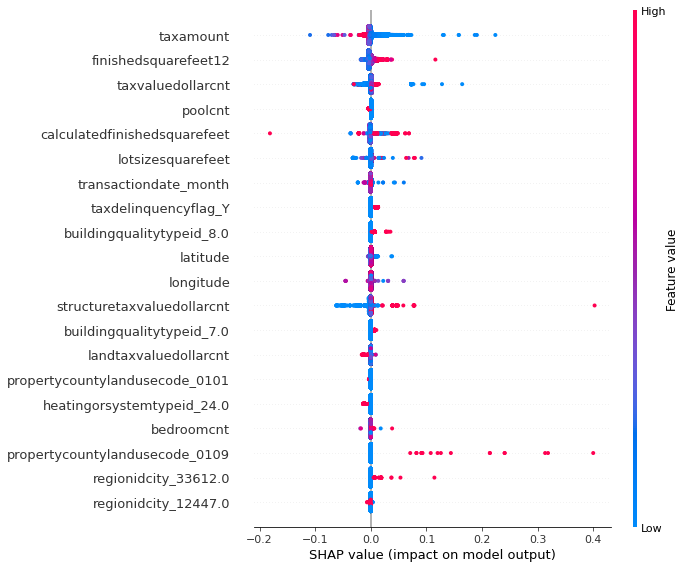

In [65]:
shap.summary_plot(shap_values, X_test_transformed)

1. **taxamount** - low values of tax amount indicates positive values of logerror. This implies that the Zestimate is higher than SalePrice
2. **finishedsquarefeet12** - higher Finished Living area square feet indicates higher logerror which implies higher Zestimate
3. **structuretaxvaluedollarcnt** - The assessed value of the built structure on the parcel - higher values indicate higher Zestimate.


We can use the shap values to explain where the logerror is positive or negative and inturn helps us understand where Zillow model is overestimating or understimating. 

### Save Model

In [108]:
joblib.dump(final_model, "../models/final_model.pkl")

['../models/final_model.pkl']